In [5]:
from src.aggregation_manager import *
from src.compression_manager import Top, Rand

import torch
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def compute_plot(X, plot_stats=True, agg_config={}, true_mu = None):
    plt.scatter(X[:, 0], X[:,1])
    if plot_stats:
            mean = Mean(agg_config).aggregate(G=X)
            co_med = CoordinateWiseMedian(agg_config).aggregate(G=X)
            geo_med = GeometricMedian(agg_config).aggregate(G=X)
            trimmed_mean = TrimmedMean(agg_config).aggregate(G=X)
            norm_clip = NormClipping(agg_config).aggregate(G=X)
            bgmd = BGMD()
            krum = Krum(agg_config).aggregate(G=X)
            
            print('Mean = {}'.format(mean))
            print('Co Median = {}'.format(co_med))
            print('Geo Med = {}'.format(geo_med))
            print('Trimmed Mean = {}'.format(trimmed_mean))
            print('Norm Clip = {}'.format(norm_clip))
            print('Krum = {}'.format(krum))
            # print('PC Pursuit = {}'.format(pc_pursuit))
            
            plt.scatter(mean[0], mean[1], c='b', marker='*', s= 200, label='Mean')
            plt.scatter(co_med[0], co_med[1], c='g', marker='*', s= 100, label='Co-Med')
            plt.scatter(geo_med[0], geo_med[1], c='k', marker='*',s= 200, label='Geo-Med')
            plt.scatter(trimmed_mean[0], trimmed_mean[1], c='c', marker='*',s= 200, label='Trimmed Mean')
            plt.scatter(norm_clip[0], norm_clip[1], c='m', marker='*',s=200, label='Norm Clip')
            plt.scatter(krum[0], krum[1], c='y', marker='*',s= 200, label='Krum')
            # plt.scatter(pc_pursuit[0], pc_pursuit[1], c='y', marker='*',s= 200, label='PC Pursuit')

    if true_mu is not None:
        plt.scatter(true_mu[:, 0], true_mu[:, 1], marker='o', label= 'True Mean')
    plt.grid(axis='both')
    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.legend()

    
def apply_compression(X, k, alg='Top'):
    if alg == 'Top':
        C = Top(k=k)
    elif alg == 'Rand':
        C = Rand(k=k)
    X_compressed = np.zeros_like(X)
    for ix in range(len(X)):
        X_compressed[ix] = C.compress(X[ix])
    return X_compressed


def apply_corruption(X, noise_mean, noise_std, n, d, co_ordinated=False):
    import copy
    X_corr = copy.deepcopy(X)
    if num_corrupt >= 1:
        if co_ordinated:
            add_noise = torch.randn(1, d) * noise_std + noise_mean
        else:
            add_noise = torch.randn(n, d) * noise_std + noise_mean

    X_corr[-num_corrupt:] = add_noise
    return X_corr

In [7]:
# Data Generation 
n = 1000
d = 2

# Create Covariance Matrix - specify Singular values 
mu = [5, 3]
var= 0.2
kappa = 2
eig=np.random.randint(1,1+kappa, d)/kappa
Sigma=np.diag(eig)
print(eig)
rotation = [[.4, -1.9],[.1, .8]]
X = np.random.normal(mu,var,(n,d))
# X=np.dot(X, Sigma)
X = np.dot(X, rotation)

true_mu = np.dot(mu, rotation)
true_mu = true_mu.reshape(1, 2)
print(true_mu)


[1.  0.5]
[[ 2.3 -7.1]]


In [8]:
# GAR Config
agg_config = {
      "pc_pursuit_config": {"num_comp": 0, "var_explained": 0.9},
      "krum_config": { "krum_frac": 0.3},
      "geo_med_config": { "geo_med_alg": 'vardi', "epsilon": 1e-3},
      "norm_clip_config": {"alpha": 0.05},
      "trimmed_mean_config": {"proportion": 0.1},
      "sketch": {"alg": 'none', "k": 0.1, "error_feedback": False} # Sketch: rcss, gscss
    }

clipping 50 clients
Mean = [ 2.29609654 -7.0824951 ]
Co Median = [ 2.29396458 -7.08655819]
Geo Med = [ 2.29495414 -7.08608695]
Trimmed Mean = [ 2.2975423  -7.08583645]
Norm Clip = [ 2.28922134 -7.03795324]
Krum = [ 2.28321648 -7.05456254]


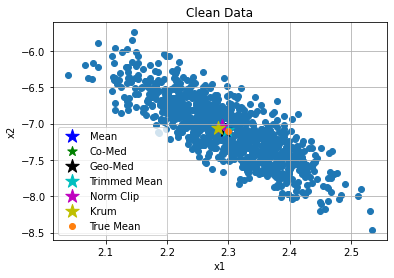

In [22]:
# Plot BaseLine 
compute_plot(X=X, agg_config=agg_config, true_mu = true_mu)
plt.title('Clean Data')
plt.legend()

In [23]:
# Byzantine Attack Config
noise_mu = 2
noise_var = 0.05
frac_adv = 0.3

clipping 50 clients
Mean = [ 2.16276904 -2.99052721]
Co Median = [ 2.18118434 -6.50908413]
Geo Med = [ 2.23792523 -6.5025511 ]
Trimmed Mean = [ 2.1602713  -3.03846631]
Norm Clip = [ 2.15020405 -2.73785824]
Krum = [1.99796999 2.00085378]


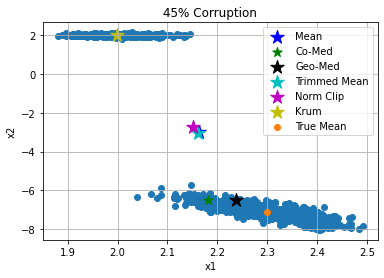

In [24]:
num_corrupt = int(frac_adv * n)
X_corrupted = apply_corruption(X, noise_mu, noise_var, num_corrupt, d)
# Plot Corrupted
compute_plot(X_corrupted, agg_config=agg_config, true_mu = true_mu)
plt.title('30% Corruption')
plt.legend()

clipping 300 clients
Mean = [0.46796924 0.44825319]
Co Median = [0. 0.]
Geo Med = [0.09348758 0.18881038]
Trimmed Mean = [0.         0.08887789]
Norm Clip = [0.21017819 0.21798331]


Text(0.5, 1.0, '40% Byzantine Corruption + Top-1 Sparsification')

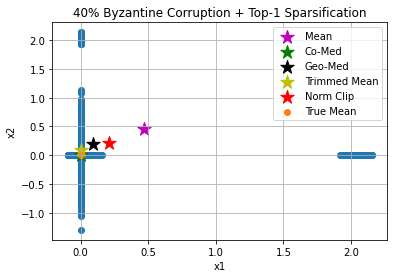

In [109]:
# Compression - Top + Corrupted
k = 0.5
X_compressed_top = apply_compression(X_corrupted, k, alg='Top')
compressed_true_mu = apply_compression(true_mu, k, alg='Top')
compute_plot(X_compressed_top, agg_config=agg_config, true_mu = compressed_true_mu)
plt.title('40% Byzantine Corruption + Top-1 Sparsification')

clipping 300 clients
Mean = [0.21774658 0.23727836]
Co Median = [0. 0.]
Geo Med = [0.06036462 0.07119031]
Trimmed Mean = [0.00290353 0.02768377]
Norm Clip = [0.09827404 0.11793645]


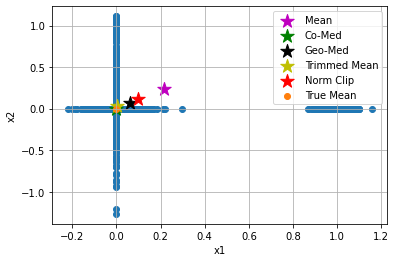

In [93]:
# Compression - Rand + Corrupted
X_compressed_top = apply_compression(X_corrupted, k, alg='Rand')
compute_plot(X_compressed_top, agg_config=agg_config, true_mu = compressed_true_mu)

In [ ]:
####### Plots Time Consumption #####

In [31]:
import json
with open('result_dumps/gm_benchmark_densenet', 'rb') as f:
    res_lenet = json.load(f)
print(res_lenet)

{'mean': 0.1996314287185669, '1': 1.743483805656433, '0.75': 1.3016281366348266, '0.5': 0.8669538974761963, '0.25': 0.43668649196624754, '0.1': 0.17336349487304686, '0.05': 0.07828385829925537, '0.01': 0.010063576698303222}


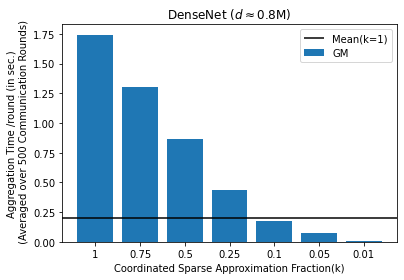

In [48]:
x= [ str(i) for i in res_lenet.keys()]
y= list(res_lenet.values())
x = x[1:]
GM = y[1:]
plt.hlines(y[0], -10,10, label='Mean(k=1)')
plt.bar(x,GM, label='GM')
plt.xlabel('Coordinated Sparse Approximation Fraction(k)')
plt.ylabel('Aggregation Time /round (in sec.)\n (Averaged over 500 Communication Rounds)')
plt.title(r'DenseNet ($d \approx $0.8M)')
plt.legend()